In [19]:
# !python.exe -m pip install --upgrade pip
# !pip install tensorflow
# !pip install --upgrade imbalanced-learn
# !pip install xgboost

In [20]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import make_scorer, precision_score, roc_auc_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Precision, AUC

import xgboost as xgb

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.mixed import MixedVariableMating, MixedVariableSampling, \
    MixedVariableDuplicateElimination
from pymoo.core.problem import StarmapParallelization
from pymoo.optimize import minimize

RND_STATE = 37
NN_METRIC = AUC
TUNING_SCORER = f1_score

# Read data

In [21]:
std_modeling = pd.read_csv('data/std_modeling.csv')
minmax_modeling = pd.read_csv('data/minmax_modeling.csv')

In [22]:
worth = std_modeling[std_modeling['worthy']==1]
not_worth = std_modeling[std_modeling['worthy']==0]
len(worth)

329

<Axes: >

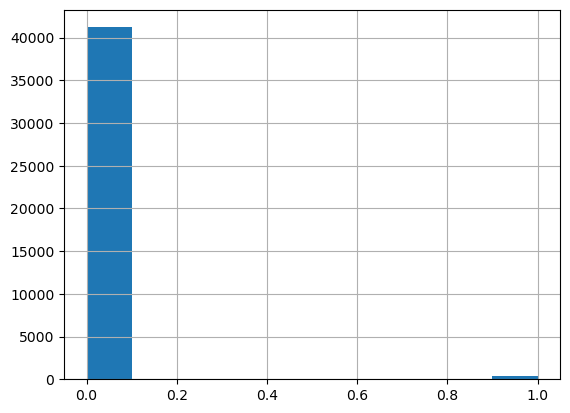

In [23]:
std_modeling['worthy'].hist()

In [24]:
X = std_modeling.drop(columns=['worthy'])
y = std_modeling['worthy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37377, 140), (4153, 140), (37377,), (4153,))

In [25]:
X_test

,priceNative,priceUsd,txns_m5_buys,txns_m5_sells,txns_h1_buys,txns_h1_sells,txns_h6_buys,txns_h6_sells,txns_h24_buy,txns_h24_sells,...,symbolVectorDim5,symbolVectorDim6,symbolVectorDim7,symbolVectorDim8,symbolVectorDim9,symbolVectorDim10,symbolVectorDim11,symbolVectorDim12,symbolVectorDim13,symbolVectorDim14
3032,-0.006126,-0.009732,-0.481984,-0.555262,-0.482032,-0.555269,-0.482032,-0.555269,-0.482032,-0.555269,...,-0.562697,0.556635,-0.441970,0.659191,0.324332,-0.737484,0.598861,0.553872,0.593890,-0.500888
5099,-0.006126,-0.009731,-0.525505,-0.567664,-0.525552,-0.567671,-0.525552,-0.567671,-0.525552,-0.567671,...,-0.682637,0.530617,-0.411907,0.569677,0.372497,-0.315730,0.564886,0.577659,0.496272,-0.585890
16692,-0.006126,-0.009732,0.366666,0.399742,0.366615,0.399729,0.366615,0.399729,0.366615,0.399729,...,-0.604765,0.517584,-0.629379,0.618498,0.987220,-0.397929,0.596537,0.516433,0.465988,-0.553485
22095,-0.006126,-0.009732,-0.068539,0.002857,-0.068589,0.002847,-0.068589,0.002847,-0.068589,0.002847,...,-0.610563,0.498607,-0.569972,0.432983,0.292896,-0.530208,0.350562,0.402958,0.467807,-0.448064
37220,-0.006126,-0.009732,1.737563,1.714422,1.737505,1.714401,1.737505,1.714401,1.737505,1.714401,...,-0.537068,0.480507,-0.587339,0.270158,0.155354,-0.602774,0.914706,0.586871,0.639237,-0.441130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,-0.006126,-0.009732,0.888913,-0.344417,0.888859,-0.344425,0.888859,-0.344425,0.888859,-0.344425,...,-0.342878,0.556595,-0.936440,0.658218,0.019387,-0.877723,0.649771,0.672649,0.753365,-0.367155
30597,-0.006126,-0.009732,4.229114,2.359360,4.229043,2.359335,4.229043,2.359335,4.229043,2.359335,...,-0.509449,0.581953,-0.908006,0.382867,0.739353,0.012532,0.796634,0.570167,0.485931,-0.558897
15142,-0.006126,-0.009732,0.606029,0.970264,0.605976,0.970247,0.605976,0.970247,0.605976,0.970247,...,-0.816176,0.695716,0.047742,0.712559,1.194070,-0.162913,0.740246,0.633058,0.427181,-0.454127
32552,-0.006126,-0.009732,-0.960710,-0.604872,-0.960755,-0.604879,-0.960755,-0.604879,-0.960755,-0.604879,...,-0.627199,0.452406,-0.235482,0.475381,-0.094601,-0.549008,0.374801,0.577204,0.481890,-0.601252


In [26]:
smote = SMOTE(random_state=None)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Dummy models

## Random Forest model (balanced)

In [27]:
# Inicjalizacja modelu Random Forest
rf_model = BalancedRandomForestClassifier(replacement=True,
                                          bootstrap=False,
                                          class_weight='balanced',
                                          sampling_strategy='all',
                                          n_jobs=-1)

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = rf_model.predict(X_test)
joblib.dump(rf_model, 'models/default_rf_model.joblib')


# Ocena modelu
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')
# Dodatkowa ocena za pomocą classification report
report = classification_report(y_test, y_pred)
print(report)

SCORES: f1: 0.0301, prec: 0.0157, auc: 0.5832

              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91      4120
         1.0       0.02      0.33      0.03        33

    accuracy                           0.83      4153
   macro avg       0.50      0.58      0.47      4153
weighted avg       0.99      0.83      0.90      4153



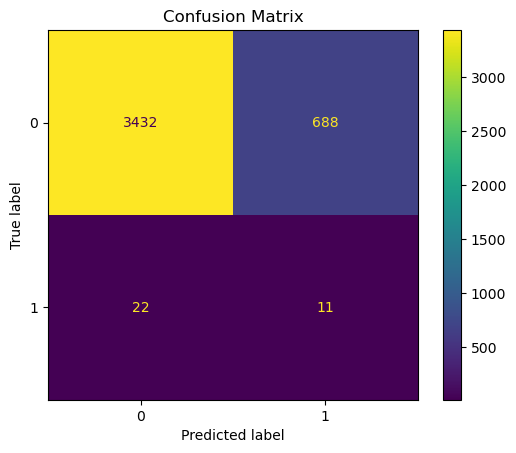

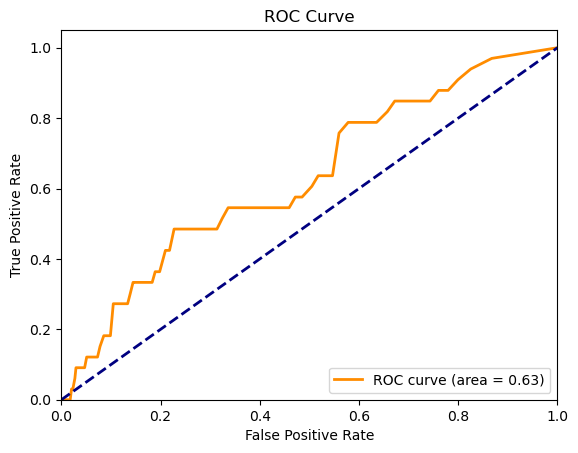

In [28]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

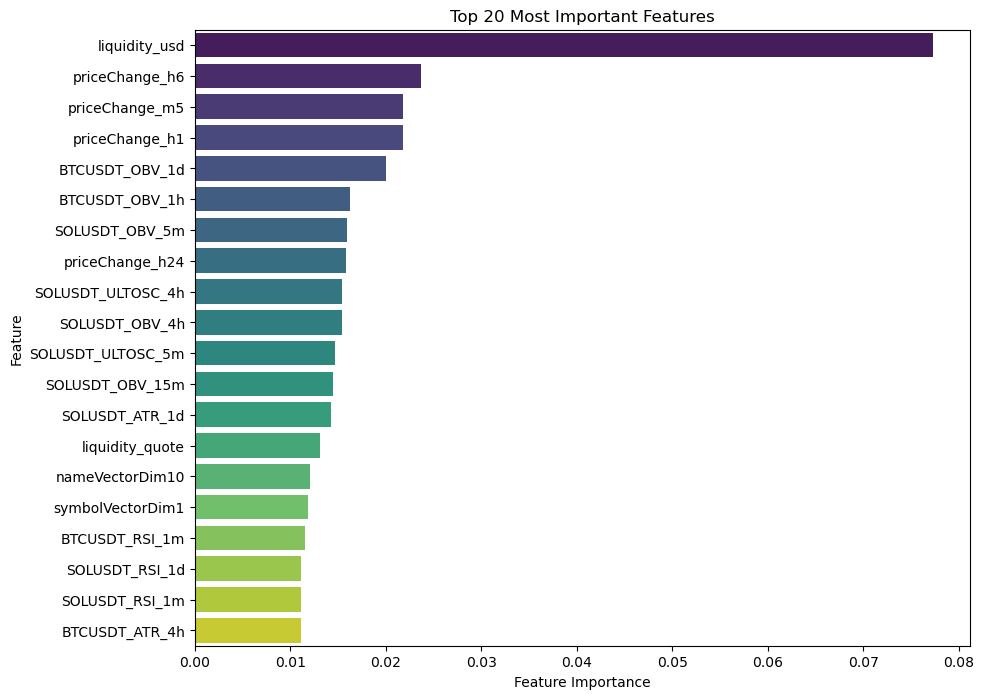

In [29]:
# Obliczanie średniej ważności cech
feature_importances = rf_model.estimators_[0].feature_importances_
for estimator in rf_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(rf_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

## Logistic regression

In [30]:
lr_model = LogisticRegression(class_weight='balanced',  max_iter=10_000)
lr_model.fit(X_train_res, y_train_res)
joblib.dump(lr_model, 'models/default_lr_model.joblib')

# Dokonaj predykcji na zestawie testowym
y_pred = lr_model.predict(X_test)

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')
print(classification_report(y_test, y_pred))

SCORES: f1: 0.0222, prec: 0.0113, auc: 0.5732

              precision    recall  f1-score   support

         0.0       0.99      0.66      0.79      4120
         1.0       0.01      0.48      0.02        33

    accuracy                           0.66      4153
   macro avg       0.50      0.57      0.41      4153
weighted avg       0.99      0.66      0.79      4153



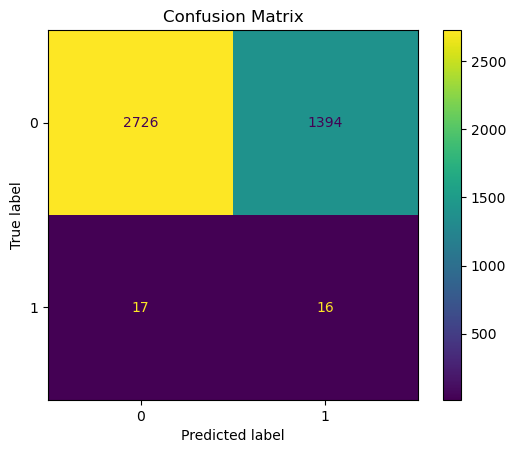

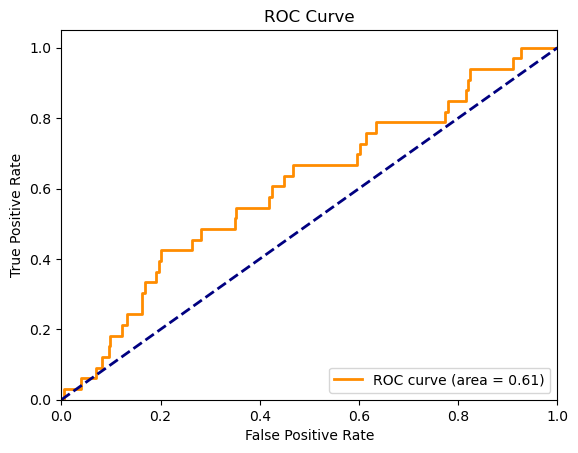

In [31]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [32]:
gb_model = xgb.XGBClassifier(device='cuda')
gb_model.fit(X_train, y_train)
joblib.dump(gb_model, 'models/default_gb_model.joblib')

['models/default_gb_model.joblib']

In [33]:
y_pred = gb_model.predict(X_test)

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

SCORES: f1: 0.1143, prec: 1.0000, auc: 0.5303

[[4120    0]
 [  31    2]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4120
         1.0       1.00      0.06      0.11        33

    accuracy                           0.99      4153
   macro avg       1.00      0.53      0.56      4153
weighted avg       0.99      0.99      0.99      4153



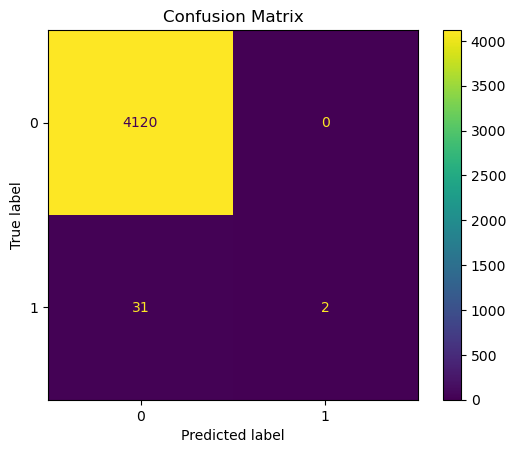

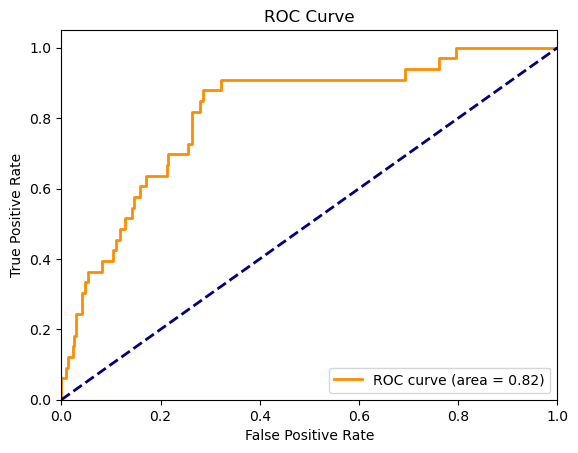

In [34]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## SVM

In [35]:
# Trenuj model SVM
svm_model = SVC(C=1.0, kernel='rbf', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, 'models/default_svm_model.joblib')

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

# Dokonaj predykcji na zestawie testowym
y_pred = svm_model.predict(X_test)

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print(classification_report(y_test, y_pred))

SCORES: f1: 0.0398, prec: 0.0217, auc: 0.5774

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      4120
         1.0       0.02      0.24      0.04        33

    accuracy                           0.91      4153
   macro avg       0.51      0.58      0.50      4153
weighted avg       0.99      0.91      0.94      4153



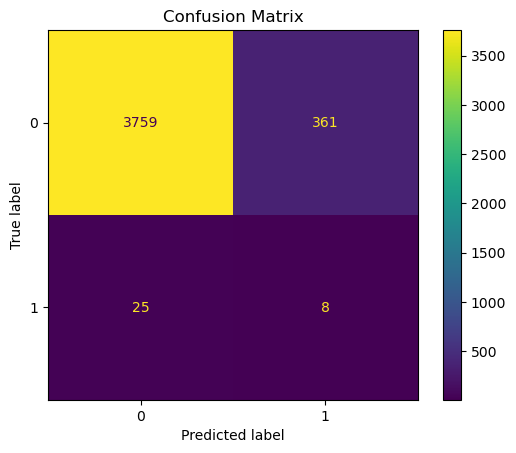

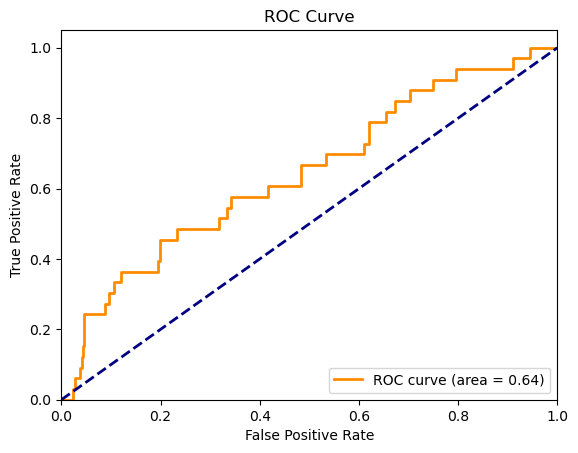

In [36]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Neural net model (not yet used)

In [ ]:
def f1_score_K(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = K.mean(f1)
    return f1

In [ ]:
# Budowa modelu z użyciem Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=10,
                               restore_best_weights=True)

# Kompilacja modelu
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[NN_METRIC()])

# Trenowanie modelu z użyciem class_weight
history = model.fit(X_train,
                    y_train,
                    epochs=250,
                    batch_size=8,
                    # class_weight=class_weights,
                    validation_split=0.1,
                    callbacks=early_stopping)

# Ewaluacja modelu
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

y_pred = (model.predict(X_test) > 0.5).astype("int32")

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Definicja metryki f1_score jako funkcji w Keras
def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Budowa modelu z użyciem Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[NN_METRIC()])

# Definicja EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=10,
                               restore_best_weights=True)

# Trenowanie modelu z użyciem class_weight
history = model.fit(X_train,
                    y_train,
                    epochs=250,
                    batch_size=8, 
                    # class_weight=class_weights,
                    validation_split=0.1,
                    callbacks=[early_stopping]
                   )

# Ewaluacja modelu
loss, f1 = model.evaluate(X_test, y_test)
print(f'Test F1 Score: {f1:.2f}')

y_pred = (model.predict(X_test) > 0.5).astype("int32")

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(f'SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}', end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Hiperparameter optimization

## Logistic regression

In [ ]:
class LogisticRegressionOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, test_size=0.2, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.test_size = test_size

        if cv_folds > 1:
            self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        
        hyperparameters = {
            "penalty": Choice(options=["l1", "l2", "elasticnet", None]),
            "dual": Binary(),
            "C": Real(bounds=(0.0001, 10_000.0)),
            "fit_intercept": Binary(),
            "intercept_scaling": Real(bounds=(0.01, 100.0)),
            "solver": Choice(options=["newton-cg", "newton-cholesky", "lbfgs", "liblinear", "sag", "saga"]),
            "l1_ratio": Real(bounds=(0.0, 1.0))  # Only used if penalty is 'elasticnet'
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        if X['solver'] in ['sag', 'newton-cg', 'newton-cholesky', 'lbfgs'] and X['penalty'] != ['l2']:
            X['penalty'] = None

        if X['solver'] == 'liblinear' and X['penalty'] not in ['l1', 'l2']:
            X['penalty'] = 'l1'

        print(f'X: {X}')
        lr = LogisticRegression(class_weight='balanced', max_iter=25,
                                penalty=X['penalty'],
                                dual=X['dual'] if X['penalty'] == 'l2' and X['solver'] == 'liblinear' else False,
                                C=X['C'] if X['penalty'] != None else 1.0,
                                fit_intercept=X['fit_intercept'],
                                intercept_scaling=X['intercept_scaling'],
                                solver=X['solver'],
                                l1_ratio=X['l1_ratio'] if X['penalty'] == 'elasticnet' else None,
                                random_state=self.rnd_state,
                                n_jobs=-1 if X['solver']!='liblinear' else None # not implemented for this solver
                               )

        if self.cv_folds == 1:
            X_train, X_test, y_train, y_test = train_test_split(self.x_data, self.y_data, test_size=self.test_size, random_state=self.rnd_state, stratify=self.y_data)
            lr.fit(X_train, y_train)
            score = self.scorer(lr, X_test, y_test)
            print(f'Single split test score: {score}', end='\n\n')
        else:
            cv_scores = cross_val_score(lr, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1)
            score = np.min(cv_scores)
            print(f'{self.cv_folds} folds cross-validated mean score: {score}', end='\n\n')
        
        out["F"] = -score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = LogisticRegressionOptimizationProblem(X_train, y_train, cv_folds=8, rnd_state=None)
algorithm = GA(pop_size=16,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "09:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f'Best gene: reward= {-res.f} variables= {res.X.items()}')
    else:
        print(f'Best gene: reward= {-res.f} variables= {res.X}')
else:
    print('Pareto front:')
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [19]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=100,
                              penalty='l1',
                              dual=False,
                              C=2890.9235583533964,
                              fit_intercept=True,
                              intercept_scaling=50.10981738069614,
                              solver='saga',
                              l1_ratio=0.7154892860473633,
                              # random_state=RND_STATE,
                              n_jobs=-1
                             )
lr_model.fit(X_train_res, y_train_res)
joblib.dump(lr_model, 'models/tuned_lr_model.joblib')

# Dokonaj predykcji na zestawie testowym
y_pred = lr_model.predict(X_test)

score = f1_score(y_test, y_pred)
print(f'Score: {score}')

print(classification_report(y_test, y_pred))

C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Score: 0.024149984111852558
              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77      8207
         1.0       0.01      0.58      0.02        66

    accuracy                           0.63      8273
   macro avg       0.50      0.60      0.40      8273
weighted avg       0.99      0.63      0.76      8273



C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


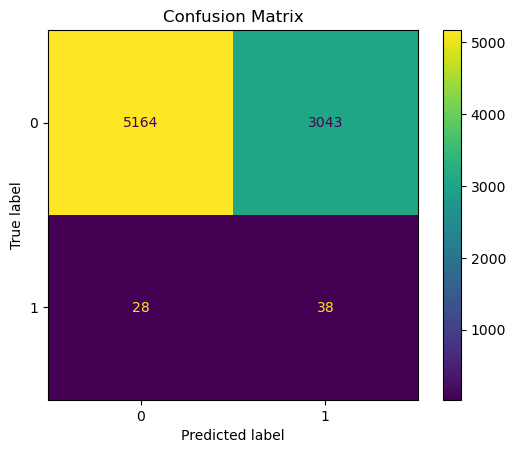

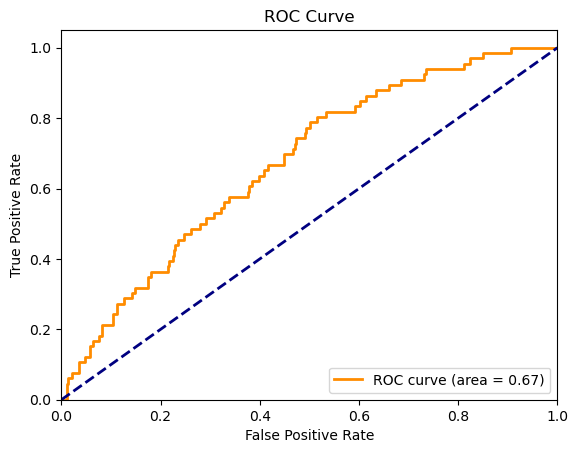

In [20]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [ ]:
class RFMixedVariableProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, test_size=0.2, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        
        if cv_folds > 1:
            self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        hyperparameters = {
            "n_estimators": Integer(bounds=(1, 500)),
            "criterion": Choice(options=["gini", "entropy"]),
            "max_depth": Integer(bounds=(1, 200)),
            "min_samples_split": Real(bounds=(.0, 1.0)),
            "min_samples_leaf": Real(bounds=(.0, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(.0, .5)),
            "max_features": Real(bounds=(0.001, 1.000)),
            "max_leaf_nodes": Integer(bounds=(2, 200)),
            "min_impurity_decrease": Real(bounds=(.0, 1.5)),
            "class_weight": Choice(options=["balanced", "balanced_subsample", None]),
            # "bootstrap": Binary(),
            # "oob_score": Binary(),
            # "warm_start": Binary(),
            # # "ccp_alpha": Real(bounds=(0.0, 10.0)),
            # "max_samples": Real(bounds=(0.001, 1.000)),
            # "monotonic_cst": Choice(options=[1, 0, -1, None])
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f'X: {X}')
        brf = BalancedRandomForestClassifier(n_jobs=-1, sampling_strategy='all', replacement=False, random_state=self.rnd_state,
            n_estimators=X['n_estimators'],
            criterion=X['criterion'],
            max_depth=X['max_depth'],
            min_samples_split=X['min_samples_split'],
            min_samples_leaf=X['min_samples_leaf'],
            min_weight_fraction_leaf=X['min_weight_fraction_leaf'],
            max_features=X['max_features'],
            max_leaf_nodes=X['max_leaf_nodes'],
            min_impurity_decrease=X['min_impurity_decrease'],
            class_weight=X['class_weight'],
            # bootstrap=X['bootstrap'],
            # oob_score=X['oob_score'] if X['bootstrap'] else False,
            # warm_start=X['warm_start'],
            # class_weight=X['class_weight'] if not X['warm_start'] else None,
            # # ccp_alpha=X['ccp_alpha'],
            # max_samples=None if not X['bootstrap'] else X['max_samples'],
            # monotonic_cst=X['monotonic_cst']
        )
        if self.cv_folds == 1:
            X_train, X_test, y_train, y_test = train_test_split(self.x_data, self.y_data, test_size=self.test_size, random_state=self.rnd_state, stratify=self.y_data)
            brf.fit(X_train, y_train)
            score = self.scorer(brf, X_test, y_test)
            print(f'Single split test score: {score}', end='\n\n')
        else:
            cv_scores = cross_val_score(brf, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1)
            score = np.mean(cv_scores)
            print(f'{self.cv_folds} folds cross-validated mean score: {score}', end='\n\n')
        
        out["F"] = -score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = RFMixedVariableProblem(X_train, y_train, cv_folds=4, rnd_state=None)
algorithm = GA(pop_size=128,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "09:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f'Best gene: reward= {-res.f} variables= {list(res.X.values())}')
    else:
        print(f'Best gene: reward= {-res.f} variables= {res.X}')
else:
    print('Pareto front:')
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Inicjalizacja modelu Random Forest
rf_model = BalancedRandomForestClassifier(n_jobs=-1, replacement=True, sampling_strategy='all',
                                  random_state=None,
                                  n_estimators=246,
                                  max_depth=156,
                                  max_leaf_nodes=24,
                                  criterion='gini',
                                  class_weight=None,
                                  min_samples_split=0.09369105882160408,
                                  min_samples_leaf=0.02751719540215013,
                                  min_weight_fraction_leaf=0.045328246137509784,
                                  max_features=0.8037848114419907,
                                  min_impurity_decrease=0.8037848114419907,
                                  # bootstrap=False,
                                  # oob_score=False,
                                  # warm_start=False
                                 )

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = rf_model.predict(X_test)
joblib.dump(rf_model, 'models/tuned_rf_model.joblib')

# Ocena modelu
accuracy = f1_score(y_test, y_pred)
print(f'Score: {accuracy}')

# Dodatkowa ocena za pomocą classification report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Obliczanie średniej ważności cech
feature_importances = rf_model.estimators_[0].feature_importances_
for estimator in rf_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(rf_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

## SVM

In [ ]:
class SVMMixedVariableProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, n_estimators=4, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.n_estimators = n_estimators
        
        self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=False, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        hyperparameters = {
            "C": Real(bounds=(0.0001, 10_000.0)),
            "kernel": Choice(options=["linear", "poly", "rbf", "sigmoid"]),
            "degree": Integer(bounds=(2, 15)),
            # "gamma": Choice(options=["scale", "auto"]),
            "gamma": Real(bounds=(.0001, 1.)), # causes problems with model
            "coef0": Real(bounds=(-15.0, 15.0)),
            "shrinking": Binary(),
            # "probability": Binary(), # False calculates faster
            # "tol": Real(bounds=(0.0001, 0.01)), # all models should have equal
            # "cache_size": Integer(bounds=(200, 1000)),
            # "class_weight": Choice(options=["balanced", None]),
            # "max_iter": Integer(bounds=(-1, 1000))
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f'X: {X}')
        try:
            svm = SVC(max_iter=50,
                      class_weight='balanced',
                      probability=False,
                      C=X['C'],
                      kernel=X['kernel'],
                      degree=X['degree'],
                      gamma=X['gamma'],
                      coef0=X['coef0'],
                      shrinking=bool(X['shrinking']),
                      # probability=bool(X['probability']),
                      # tol=X['tol'], # stopping criterion, may cause troubles
                      # cache_size=X['cache_size'],
                      # class_weight=X['class_weight'],
                      # max_iter=X['max_iter']
                     )
            # b_svc= BaggingClassifier(svm,
            #                          max_samples=1.0 / self.n_estimators,
            #                          n_estimators=self.n_estimators,
            #                          n_jobs=-1)
            cv_scores = cross_val_score(svm,
                                        self.x_data,
                                        self.y_data,
                                        cv=self.skf,
                                        scoring=self.scorer,
                                        error_score='raise', n_jobs=-1)
            mean_f1 = np.mean(cv_scores)
            print(f'{self.cv_folds} folds cross-validated mean score: {mean_f1}', end='\n\n')
            out["F"] = -mean_f1
        except Exception as e:
            print(e)
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(f'Model failure with prameters: {X}')
            print(f'{self.cv_folds} folds cross-validated mean score: -{np.inf}', end='\n\n')
            out["F"] = np.inf
            # raise e

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = SVMMixedVariableProblem(X_train, y_train, cv_folds=4, n_estimators=4, rnd_state=None)
algorithm = GA(pop_size=128,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "08:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f'Best gene: reward= {-res.f} variables= {res.X.items()}')
    else:
        print(f'Best gene: reward= {-res.f} variables= {res.X}')
else:
    print('Pareto front:')
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Trenuj model SVM

svm_model = SVC(max_iter=-1,
                C=8149.480638948695,
                coef0=-13.40974924059736,
                # tol=0.007392566629174455,
                kernel='rbf',
                gamma=0.028951614538558074,
                class_weight='balanced',
                degree=15,
                shrinking=False,
                probability=True)

# n_estimators = 4
# b_svc= BaggingClassifier(svm_model, max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1)
# b_svc.fit(X_train, y_train)

svm_model.fit(X_train_res, y_train_res)
joblib.dump(svm_model, 'models/tuned_svm_model.joblib')

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

score = f1_score(y_test, y_pred)
print(f'Score: {score}')

print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost (edit needed)

In [ ]:
class GradientBoostingOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state

        self.skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        self.scorer = make_scorer(TUNING_SCORER)
        
        hyperparameters = {
            "loss": Choice(options=["log_loss", "exponential"]),
            "learning_rate": Real(bounds=(0.001, 1000.0)),
            "n_estimators": Integer(bounds=(5, 500)),
            "subsample": Real(bounds=(0.01, 1.0)),
            "criterion": Choice(options=["friedman_mse", "squared_error"]),
            "min_samples_split": Real(bounds=(0.001, 1.0)),
            "min_samples_leaf": Real(bounds=(0.001, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(0.0, 0.5)),
            "max_depth": Integer(bounds=(1, 100)),
            "min_impurity_decrease": Real(bounds=(0.0, 100.0)),
            "max_features": Choice(options=["sqrt", "log2", None]),
            "max_leaf_nodes": Integer(bounds=(2, 100), strict=False),
            "validation_fraction": Real(bounds=(0.01, 0.5))
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f'X: {X}')
        gbc = GradientBoostingClassifier(
            loss=X['loss'],
            learning_rate=X['learning_rate'],
            n_estimators=X['n_estimators'],
            subsample=X['subsample'],
            criterion=X['criterion'],
            min_samples_split=X['min_samples_split'],
            min_samples_leaf=X['min_samples_leaf'],
            min_weight_fraction_leaf=X['min_weight_fraction_leaf'],
            max_depth=X['max_depth'],
            min_impurity_decrease=X['min_impurity_decrease'],
            max_features=X['max_features'],
            max_leaf_nodes=X['max_leaf_nodes'],
            validation_fraction=X['validation_fraction'],
            random_state=self.rnd_state
        )
        
        cv_scores = cross_val_score(gbc, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1)
        mean_f1_score = np.mean(cv_scores)
        print(f'{self.cv_folds} folds cross-validated mean score: {mean_f1_score}', end='\n\n')
        
        out["F"] = -mean_f1_score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = GradientBoostingOptimizationProblem(X_train, y_train, cv_folds=4, rnd_state=None)
algorithm = GA(pop_size=64,
               sampling=MixedVariableSampling(),
               mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
               eliminate_duplicates=MixedVariableDuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=("time", "02:00:00"),
               # termination=("n_gen", 50),
               verbose=True)

In [ ]:
# scores = []
# for i in range(2, 25):
#   kmeans = KMeans(n_clusters=i)
#   clusters = kmeans.fit_predict(std_modeling.drop(columns=['worthy']))

#   # Ewaluacja klastrów
#   score = silhouette_score(std_modeling, clusters)
#   print(f"k={i} Silhouette Score: {score}")
#   scores.append(score)

In [ ]:
from tensorflow.keras import callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Objective
from keras_tuner.tuners import BayesianOptimization

from datetime import datetime

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        # Pierwsza warstwa Dense
        model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=256, step=8),
                        activation=hp.Choice('activation_input', ['relu', 'elu']),
                        kernel_regularizer=regularizers.l2(hp.Float('l2_input', min_value=1e-5, max_value=1e-1)),
                        input_shape=(self.input_shape,)))

        # Opcjonalna warstwa BatchNormalization po pierwszej warstwie Dense
        if hp.Boolean('batch_norm_input'):
            model.add(BatchNormalization())

        # Opcjonalna warstwa Dropout po pierwszej warstwie Dense
        if hp.Boolean('dropout_input'):
            model.add(Dropout(rate=hp.Float('dropout_input_rate', min_value=0.0, max_value=0.75, step=0.05)))

        # Dodatkowe warstwy Dense
        for i in range(hp.Int('num_layers', 1, 8)):
            model.add(Dense(units=hp.Int(f'units_layer_{i}', min_value=16, max_value=256, step=16),
                            activation=hp.Choice(f'activation_{i}', ['relu', 'elu']),
                            kernel_regularizer=regularizers.l2(hp.Float(f'l2_layer_{i}', min_value=1e-5, max_value=1e-1)) if hp.Boolean(f'l2_layer_{i}_reg') else None))

            # Opcjonalna warstwa Dropout po każdej dodatkowej warstwie Dense
            model.add(Dropout(rate=hp.Float(f'dropout_layer_{i}', min_value=0.0, max_value=0.5, step=0.05)))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2)),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice('batch_size', values=[2, 4, 8, 16, 32]),
            **kwargs,
        )

hypermodel = MyHyperModel(input_shape=X_train_scaled.shape[1])

tuner = BayesianOptimization(
    hypermodel,
    objective=Objective("val_accuracy", direction="max"),
    max_trials=100,
    executions_per_trial=2,
    directory=f'search{datetime.now()}',
    project_name=f'dupxo{datetime.now()}'
)

# Rozpocznij proces wyszukiwania. Pamiętaj, aby zastąpić `X_train_scaled`, `y_train` swoimi danymi.
tuner.search(X_train_scaled, y_train,
             epochs=500,
            #  batch_size=16,
             validation_split=0.2,
             callbacks=[callbacks.EarlyStopping(monitor='loss',
                                                mode='min',
                                                patience=5,
                                                verbose=1)])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('/content/drive/MyDrive/models/token_selectioner_best_model.h5')

tuner.results_summary()
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')